In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random

In [4]:
if torch.cuda.is_available():
     torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [5]:
# Define a simple MLP model for regression with 5 hidden layers
class MLPRegressor(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLPRegressor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, 1)  # Output layer with one node for regression

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        return out

In [6]:
# Define a simple MLP model for regression with 5 hidden layers
class adaptiveMLPRegressor(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(adaptiveMLPRegressor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, 1)  # Output layer with one node for regression
        
    def forward(self, x, gamma_beta_lst):
        out = self.fc1(x)
        out = out * gamma_beta_lst[0]['gamma'] + gamma_beta_lst[0]['beta']
        out = self.relu(out)

        out = self.fc2(out)
        out = out * gamma_beta_lst[1]['gamma'] + gamma_beta_lst[1]['gamma']
        out = self.relu(out)

        out = self.fc3(out)
        out = out * gamma_beta_lst[2]['gamma'] + gamma_beta_lst[2]['gamma']
        out = self.relu(out)

        out = self.fc4(out)
        out = out * gamma_beta_lst[3]['gamma'] + gamma_beta_lst[3]['gamma']
        out = self.relu(out)

        out = self.fc5(out)
        
        return out

In [7]:
def getEmbeddings(X, y):
    embeding = torch.concat((X, y), dim=0).flatten()
    # print(embeding.shape)
    assert embeding.shape[0] == 20
    return embeding

In [8]:
class gammaAdaptationNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(gammaAdaptationNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc3 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc4 = nn.Linear(hidden_size, 128)  # Output layer with one node for regression
        
    def forward(self, embeddings):
        out = self.fc1(embeddings)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        return out

In [9]:
class betaAdaptationNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(betaAdaptationNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc3 = nn.Linear(hidden_size, hidden_size)  # Output layer with one node for regression
        self.fc4 = nn.Linear(hidden_size, 128)  # Output layer with one node for regression
        
    def forward(self, embeddings):
        out = self.fc1(embeddings)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        return out

In [10]:
class adaptationNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(adaptationNetwork, self).__init__()

        self.gammaNetProcessors, self.betaNetProcessors = torch.nn.ModuleList(), torch.nn.ModuleList()

        for i in range(4):
            self.gammaNetProcessors.append(gammaAdaptationNetwork(input_size, hidden_size))
            self.betaNetProcessors.append(betaAdaptationNetwork(input_size, hidden_size))
        
    def forward(self, X, y):
        gamma_beta_lst = []
        embeddings = getEmbeddings(X, y)
        for i in range(4):
            gamma_beta_dict = {'gamma': self.gammaNetProcessors[i](embeddings), 'beta': self.betaNetProcessors[i](embeddings)}
            gamma_beta_lst.append(gamma_beta_dict)
        return gamma_beta_lst

In [11]:
def get_sine(sine_params, X, i):
    torch.manual_seed(0)
    return sine_params[i][0] * torch.sin(sine_params[i][1] * X + sine_params[i][2]) + sine_params[i][3] + torch.randn(X.shape) * 0.1

In [12]:
#               [A, w, phi, B]
sine_params = [ [1, 1, 0, 0],           # 0
                [2, 1, 0, 0],           # 1
                [1, 2, 0, 0],           # 2
                [0.9, 1.5, 0.3, 0.5],   # 3
                [1, 1, 2, 0],         # 4
                [4, 0.6, 0.9, -2],      # 5
                [1.7, 4, 3.17, 0],       # 6
                [3, 2, 2.19, 0.1],      # 7
                [2, 1.5, 0, 0.5],       # 8
                [2.5, 3, 3, 2],         # 9
                [1.2, 1, 0, 0.8]]       # 10

sine_params = torch.tensor(sine_params)

# Generate synthetic data for regression
torch.manual_seed(0)

dataset = [None] * 11  # List of datasets for each function

for i in range(11):
    upper_bound = 2 * torch.pi / sine_params[i][1]
    X = torch.linspace(0, upper_bound, 500)
    y = get_sine(sine_params, X, i)  # Sine function with noise
    X_y = torch.cat((X.unsqueeze(1), y.unsqueeze(1)), 1)
    dataset[i] = X_y

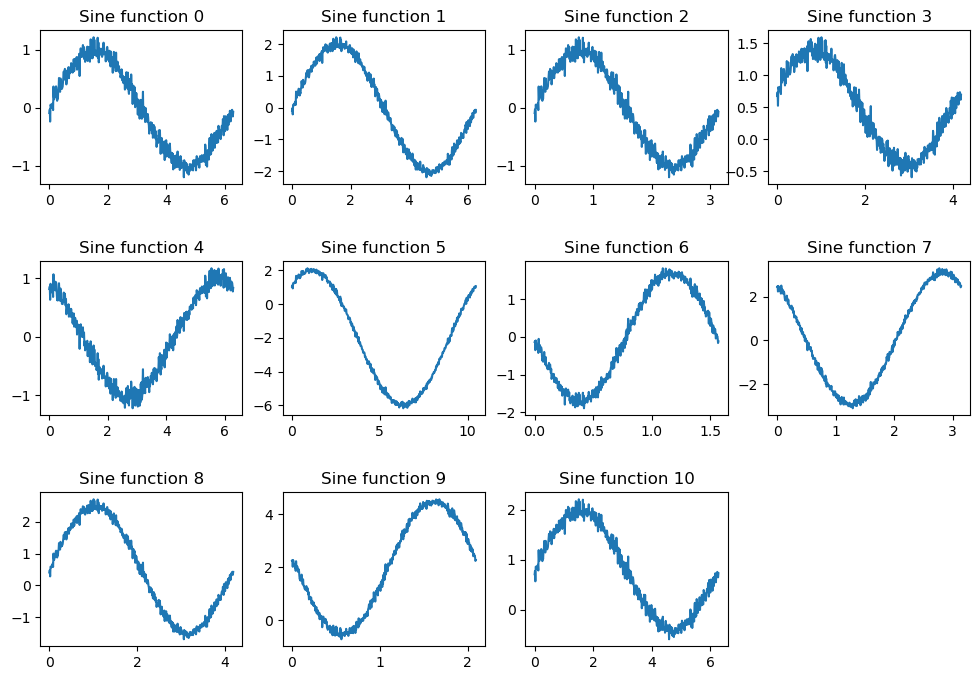

In [14]:
# plot 11 sine functions and adjust margins
plt.figure(figsize=(12, 8))
plt.subplots_adjust(hspace=0.5)

for i in range(11):
    plt.subplot(3, 4, i+1)
    plt.plot(dataset[i][:, 0].cpu(), dataset[i][:, 1].cpu())
    plt.title('Sine function {}'.format(i))

In [18]:
len(dataset[0])
dataset[0].type()

'torch.cuda.FloatTensor'

In [19]:
newdataset = []

for i in range(0, 11):
    torch.manual_seed(i)
    num_elements = dataset[i].shape[0]
    permuted_indices = torch.randperm(num_elements) # Generate a random permutation of indices
    dataset[i] = dataset[i][permuted_indices]

    # i=0 case will be used for training of main network, therefore, kept intact. Others will be used for meta learning and testing, therefore devided in chunks of 50
    if i>=1:
        for j in range(int(dataset[i].shape[0] / 50)):
            newdataset.append(dataset[i][j*50:(j+1)*50,:])

In [20]:
print('len(newdataset): ', len(newdataset))
print('len(newdataset[0]): ', len(newdataset[0]))
print('newdataset[0]: ', newdataset[0])
print('newdataset[1]: ', newdataset[1])

len(newdataset):  100
len(newdataset[0]):  50
newdataset[0]:  tensor([[ 2.2035,  1.7672],
        [ 3.5508, -0.8565],
        [ 3.3242, -0.3229],
        [ 1.2340,  1.7969],
        [ 3.5005, -0.6110],
        [ 2.5561,  1.0803],
        [ 3.7523, -1.0885],
        [ 0.5540,  1.0342],
        [ 0.2896,  0.4414],
        [ 2.5687,  1.0145],
        [ 0.8436,  1.3762],
        [ 4.3945, -1.8739],
        [ 1.5614,  1.9097],
        [ 4.3441, -1.7481],
        [ 2.7701,  0.7558],
        [ 2.8709,  0.6466],
        [ 5.5781, -1.3875],
        [ 2.1909,  1.5045],
        [ 4.8729, -2.0507],
        [ 1.0703,  1.8992],
        [ 5.4018, -1.5687],
        [ 2.3672,  1.4177],
        [ 5.8928, -0.6921],
        [ 4.8477, -1.9684],
        [ 0.0755,  0.0887],
        [ 3.2360, -0.0798],
        [ 0.1763,  0.4794],
        [ 4.8100, -1.9735],
        [ 4.7344, -2.0257],
        [ 0.1889,  0.4937],
        [ 2.1657,  1.4307],
        [ 2.1028,  1.8274],
        [ 3.0849, -0.1320],
        [ 5.14

In [27]:
random.seed(0)
train_dataset = newdataset[:80]
random.shuffle(train_dataset)       # Shuffle the dataset in-place
test_dataset = newdataset[80:]
random.shuffle(test_dataset)

In [28]:
# Training base model

# Hyperparameters
input_size = 1  # One input feature
hidden_size = 128  # Number of neurons in each hidden layer
learning_rate = 0.01
num_epochs = 500

# Initialize the MLP regression baseModel
baseModel = MLPRegressor(input_size, hidden_size)

# Loss and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer = optim.Adam(baseModel.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    # Forward pass
    outputs = baseModel(dataset[0][:400, 0].unsqueeze(1))
    loss = criterion(outputs, dataset[0][:400, 1].unsqueeze(1))

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Make predictions
with torch.no_grad():
    # predicted = baseModel(X)
    predicted = baseModel(dataset[0][400:, 0].unsqueeze(1))

# print("Predicted values:")
# print(predicted)

# Save the trained baseModel
torch.save(baseModel.state_dict(), 'checkpoints/baseModel.ckpt')
print('MLP regression baseModel with 5 hidden layers trained and saved!')

Epoch [100/500], Loss: 0.0094
Epoch [200/500], Loss: 0.0092
Epoch [300/500], Loss: 0.0100
Epoch [400/500], Loss: 0.0090
Epoch [500/500], Loss: 0.0091
MLP regression baseModel with 5 hidden layers trained and saved!


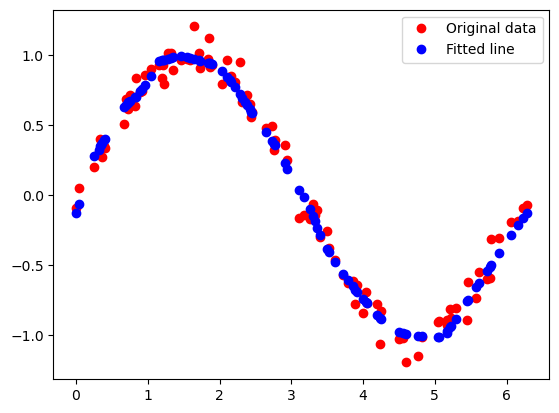

In [29]:
# plot x and y
plt.plot(dataset[0][400:, 0].unsqueeze(1).cpu(), dataset[0][400:, 1].unsqueeze(1).cpu(), 'ro', label='Original data')
plt.plot(dataset[0][400:, 0].unsqueeze(1).cpu(), predicted.cpu(), 'bo', label='Fitted line')
plt.legend()
plt.show()

In [34]:
# Training meta model

# Hyperparameters
input_size = 1  # One input feature
hidden_size = 128  # Number of neurons in each hidden layer
learning_rate = 0.01
num_epochs = 50

# Initialize the MLP regression baseModel
adaptiveModel = adaptiveMLPRegressor(input_size, hidden_size)

# load the trained baseModel
adaptiveModel.load_state_dict(torch.load('checkpoints/baseModel.ckpt'))
adaptiveNetwork = adaptationNetwork(20, hidden_size)

# freez the weights of the baseModel
for param in adaptiveModel.parameters():
    param.requires_grad = False

# Loss and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer = optim.Adam(adaptiveNetwork.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for training_task in train_dataset:
        context = training_task[:10]
        target_x = training_task[10:, 0].unsqueeze(1)
        target_y = training_task[10:, 1].unsqueeze(1)
        gamma_beta_lst = adaptiveNetwork.forward(context[:, 0], context[:, 1])

        predictions = adaptiveModel(target_x, gamma_beta_lst)
        loss = criterion(predictions, target_y)
        # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Make predictions
with torch.no_grad():
    for test_task in train_dataset:
        context = test_task[:10]
        target_x = test_task[10:, 0].unsqueeze(1)
        target_y = test_task[10:, 1].unsqueeze(1)
        gamma_beta_dict = adaptiveNetwork.forward(context[:, 0], context[:, 1])
        predictions = adaptiveModel(target_x, gamma_beta_dict)
        # print("loss: ", criterion(predictions, target_y))


# print("Predicted values:")
# print(predicted)

# Save the trained adaptiveModel
torch.save(adaptiveModel.state_dict(), 'checkpoints/adaptiveNetwork.ckpt')
print('adaptiveModel trained and saved!')

Epoch [1/50], Loss: 13.4439
Epoch [2/50], Loss: 113.2800
Epoch [3/50], Loss: 13.0525
Epoch [4/50], Loss: 13.3594
Epoch [5/50], Loss: 9.4810
Epoch [6/50], Loss: 13.0732
Epoch [7/50], Loss: 13.7585
Epoch [8/50], Loss: 13.0026
Epoch [9/50], Loss: 13.1383
Epoch [10/50], Loss: 67.3087
Epoch [11/50], Loss: 13.9836
Epoch [12/50], Loss: 12.7848
Epoch [13/50], Loss: 26.7057
Epoch [14/50], Loss: 9.0342
Epoch [15/50], Loss: 227.9673
Epoch [16/50], Loss: 12.7509
Epoch [17/50], Loss: 13.1670
Epoch [18/50], Loss: 13.4949
Epoch [19/50], Loss: 12.7139
Epoch [20/50], Loss: 13.3125
Epoch [21/50], Loss: 13.1637
Epoch [22/50], Loss: 13.0405
Epoch [23/50], Loss: 12.9501
Epoch [24/50], Loss: 12.8510
Epoch [25/50], Loss: 12.7516
Epoch [26/50], Loss: 12.6453
Epoch [27/50], Loss: 12.4698
Epoch [28/50], Loss: 12.2495
Epoch [29/50], Loss: 12.1964
Epoch [30/50], Loss: 8.0503
Epoch [31/50], Loss: 12.7109
Epoch [32/50], Loss: 12.4570
Epoch [33/50], Loss: 12.1934
Epoch [34/50], Loss: 9.2149
Epoch [35/50], Loss: 7.15

# No

In [101]:
# def get_sine(A, B, w, phi, x):
#     torch.manual_seed(0)
#     return A * torch.sin(w * x + phi) + B + torch.randn(x.shape) * 0.1

In [110]:
# Hyperparameters
input_size = 1  # One input feature
hidden_size = 128  # Number of neurons in each hidden layer
learning_rate = 0.01
num_epochs = 5000

# Generate synthetic data for regression
torch.manual_seed(0)
A = 2.0
B = 1.0
w = 2.0
phi = 0.1
upper_bound = 2 * torch.pi / w
X = torch.linspace(0, upper_bound, 100).reshape(100, input_size)
y = get_sine(A, B, w, phi, X)  # Sine function with noise


# Initialize the MLP regression model
# model = MLPRegressor(input_size, hidden_size)
model = adaptiveMLPRegressor(input_size, hidden_size)

# Loss and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    # Forward pass
    # outputs = model(X)
    outputs = model(X, y)
    loss = criterion(outputs, y)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Make predictions
with torch.no_grad():
    # predicted = model(X)
    predicted = model(X, y)

# print("Predicted values:")
# print(predicted)

# Save the trained model
torch.save(model.state_dict(), 'checkpoints/mlp_regression_model_5hiddenlayers.ckpt')
print('MLP regression model with 5 hidden layers trained and saved!')

encoder1_output.shape:  torch.Size([100, 1])
film1_output.shape:  torch.Size([100, 2])
encoder1_output.shape:  torch.Size([100, 1])
film1_output.shape:  torch.Size([100, 2])
encoder1_output.shape:  torch.Size([100, 1])
film1_output.shape:  torch.Size([100, 2])
encoder1_output.shape:  torch.Size([100, 1])
film1_output.shape:  torch.Size([100, 2])
encoder1_output.shape:  torch.Size([100, 1])
film1_output.shape:  torch.Size([100, 2])
encoder1_output.shape:  torch.Size([100, 1])
film1_output.shape:  torch.Size([100, 2])
encoder1_output.shape:  torch.Size([100, 1])
film1_output.shape:  torch.Size([100, 2])
encoder1_output.shape:  torch.Size([100, 1])
film1_output.shape:  torch.Size([100, 2])
encoder1_output.shape:  torch.Size([100, 1])
film1_output.shape:  torch.Size([100, 2])
encoder1_output.shape:  torch.Size([100, 1])
film1_output.shape:  torch.Size([100, 2])
encoder1_output.shape:  torch.Size([100, 1])
film1_output.shape:  torch.Size([100, 2])
encoder1_output.shape:  torch.Size([100, 1]

In [111]:
X.shape

torch.Size([100, 1])

In [112]:
y.shape

torch.Size([100, 1])

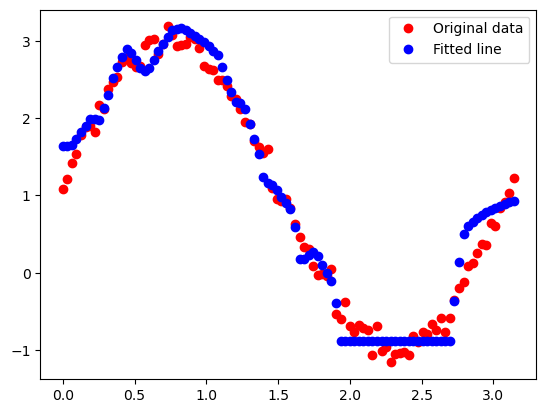

In [113]:
# plot x and y
plt.plot(X, y, 'ro', label='Original data')
plt.plot(X, predicted, 'bo', label='Fitted line')
plt.legend()
plt.show()

In [ ]:
# class CNAPSRegression(nn.Module):
#     def __init__(self, input_size, hidden_size, num_tasks):
#         super(CNAPSRegression, self).__init__()
#         self.num_tasks = num_tasks
#         self.task_embeddings = nn.Embedding(num_tasks, hidden_size)
#         self.mlp = MLPRegressor(input_size + hidden_size, hidden_size)

#     def forward(self, x, task):
#         task_embedding = self.task_embeddings(task)
#         out = torch.cat((x, task_embedding), dim=1)
#         out = self.mlp(out)
#         return out

In [ ]:
# class Encoder(nn.Module):
#     def __init__(self, input_size, hidden_size = 64):
#         super(Encoder, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_size, hidden_size)
#         self.fc3 = nn.Linear(hidden_size, 1)

#     def forward(self, x):
#         out = self.fc1(x)
#         out = self.relu(out)
#         out = self.fc2(out)
#         out = self.relu(out)
#         out = self.fc3(out)
#         return out

In [ ]:
# class FiLM(nn.Module):
#     def __init__(self, input_size=3, hidden_size = 64):    # input_size = 3 corresponding to (x, y, encoder_output)
#         super(FiLM, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_size, hidden_size)
#         self.fc3 = nn.Linear(hidden_size, 2)

#     def forward(self, x):
#         out = self.fc1(x)
#         out = self.relu(out)
#         out = self.fc2(out)
#         out = self.relu(out)
#         out = self.fc3(out)
#         return out